# Maximum Likelihood Estimation

## Probability distribution case

In [1]:
import numpy as np
import matplotlib.pyplot as plt

(1000,)


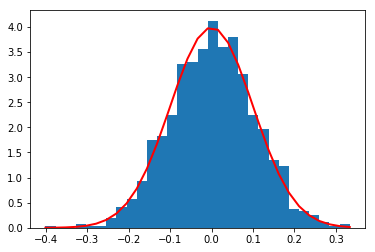

In [2]:
mu, sigma = 0, 0.1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 1000)
print(data.shape)

count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [3]:
from UQpy.Inference import Model
candidate_model = Model(model_type = 'pdf', model_name='normal')

In [4]:
from UQpy.Inference import MLEstimation
ml_estimator = MLEstimation(model=candidate_model, data=data)
print('ML estimates of the mean={0:.3f} and std. dev={1:.3f}'.format(ml_estimator.param[0], ml_estimator.param[1]))

ML estimates of the mean=0.002 and std. dev=0.102


## Regression model (model linear in the parameters)

In [5]:
# Generate data
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape((1, -1))
error_covariance = np.eye(50)

print(param_true.shape)
from UQpy.RunModel import RunModel
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_1', 'theta_2'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[ 1.02647953e+00  2.82381078e-01 -3.94392606e-02  3.26791698e-01
  2.18428188e+00  1.85914609e+00  3.65514268e+00  5.67871164e+00
  6.38557513e+00  9.27878385e+00  1.06459783e+01  1.23223979e+01
  1.37999225e+01  1.57696354e+01  1.97177634e+01  2.05702181e+01
  2.45155939e+01  2.51031196e+01  3.09117620e+01  3.52301772e+01
  3.78315381e+01  4.18361320e+01  4.49559563e+01  4.98436945e+01
  5.26293590e+01  5.62402554e+01  6.37845842e+01  6.67948515e+01
  7.01959873e+01  7.74941939e+01  8.32055679e+01  8.69417178e+01
  9.12647012e+01  9.77274842e+01  1.04610788e+02  1.09335723e+02
  1.14501578e+02  1.23824235e+02  1.26178795e+02  1.34555079e+02
  1.41379194e+02  1.48215694e+02  1.54305058e+02  1.61959743e+02
  1.70943348e+02  1.77221918e+02  1.86400605e+02  1.94650413e+02
  2.02140191e+02  2.09501633e+02]


In [6]:
candidate_model = Model(n_params=2, model_type='python', 
                        model_script='pfn_models.py', model_object_name = 'model_quadratic', 
                        error_covariance=error_covariance)

In [7]:
ml_estimator = MLEstimation(model=candidate_model, data=data)

(1, 2)
Optimization terminated successfully.
         Current function value: 69.981174
         Iterations: 63
         Function evaluations: 122


In [8]:
print(ml_estimator.param)

[1.04366949 1.99668505]
